In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#root_path = '/content/gdrive/My Drive/Colab Notebooks/MyModel'
#import sys
#sys.path.append(root_path)
#https://github.com/huyvnphan/PyTorch-CIFAR10/blob/master/CIFAR10.ipynb

In [1]:
import torch
import torchvision
from torchvision import models
import torch.nn as nn
import torch.utils.data
import os
import torch.nn.functional as F
import time

#plots
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.ticker as ticker

#math
import numpy as np
from numpy.random import random
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm

#modules
from cifar10_models import resnet
import data_loader
import visualize
import train_model
import FGSM
import augment
import utility

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


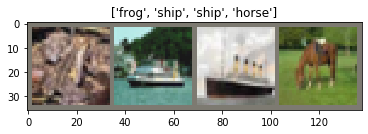

In [2]:
#LOAD DATA
batch_size=4
trainloader, testloader, attributes=data_loader.load_cifar10(batch_size)
N_test=attributes["N_test"]
N_train=attributes["N_train"]
classes=attributes["class_names"]

# VISUALIZE
inputs, class_data = next(iter(trainloader))
visualize.imshow(inputs, title=[classes[i] for i in class_data])

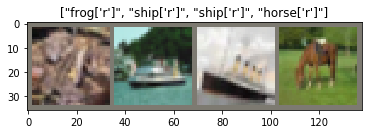

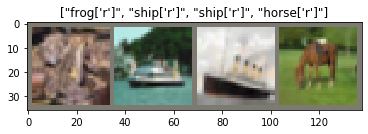

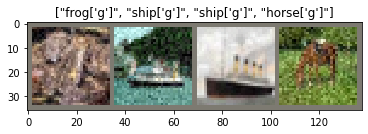

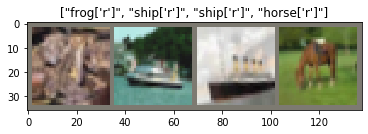

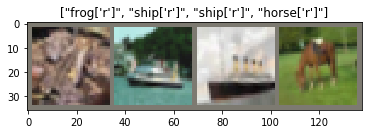

In [3]:
# TEST AUGMENTATION OF BATCH
aug_batches, aug_seqs, aug_seqs_names = augment.compute_augmentations(inputs, n = 5, depth = 1, augmentations="r,g")
for i, _ in enumerate(aug_seqs_names):
    visualize.imshow(aug_batches[i], title=[classes[j]+str(aug_seqs_names[i]) for j in class_data])
    plt.pause(0.001)
    
# pause a bit so that plots are updated

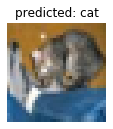

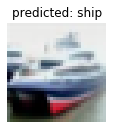

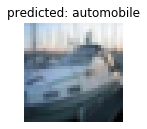

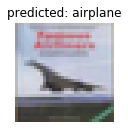

In [7]:
#load the pretrained resnet 18/34 or 50
model = resnet.resnet50(pretrained=True).to(device)
#train if necessary
#model_ft = train_model.train(model, trainloader, testloader,num_epochs=2, batch_size=batch_size)

path="cifar10_models/state_dicts/resnet50.pt"
model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))
model.eval()
visualize.visualize_model(model, testloader, classes, num_images=4)

## FGSM


In [5]:
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, testloader, epsilon=0, augmentations = "none",v = 1)

25%
50%
75%
100%
Epsilon: 0	Test Accuracy = 9348 / 10000 = 0.9348


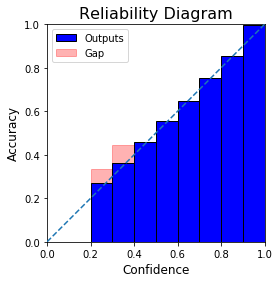

In [6]:
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=cal_statistics(target, pred_log_prob)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
utility.reliability_diagram_plot(bin_accs, bin_confs, title="Reliability Diagram")


In [5]:
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, testloader, epsilon=0, augmentations = "all", n = 21, v = 1)

25%
50%
75%
100%
Epsilon: 0	Test Accuracy = 9330 / 10000 = 0.933


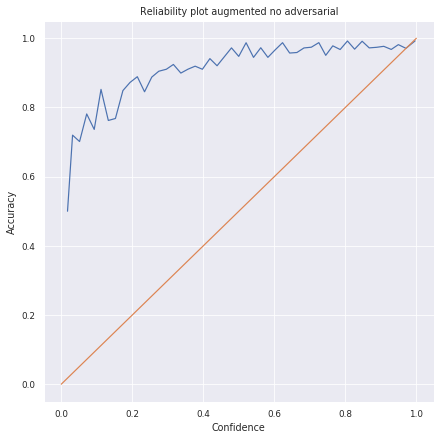

In [56]:
utility.plot_reliability(predicted_probs_aug, real_labels_aug, title="Reliability plot augmented no adversarial")

In [7]:
final_acc_adv, adv_examples_adv, pred_log_probs_adv, target_labels_adv = FGSM.test_augmented(model, testloader, epsilon=0.3, augmentations = "all", n = 21, v = 1)

25%
50%
75%
100%
Epsilon: 0.3	Test Accuracy = 3410 / 10000 = 0.341


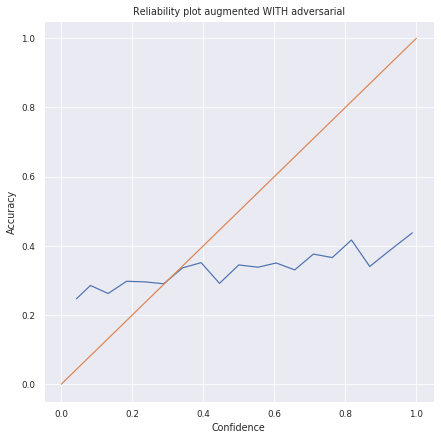

In [54]:
utility.plot_reliability(predicted_probs_aug_adv, real_labels_aug_adv, title="Reliability plot augmented WITH adversarial")

In [6]:
final_acc_aug_adv, adv_examples_aug_adv, predicted_probs_aug_adv, real_labels_aug_adv = FGSM.test_augmented(model, testloader, epsilon=0.3, augmentations = "r", n = 21, v = 1)

Epsilon: 0	Test Accuracy = 7809 / 10000 = 0.7809


In [7]:
final_acc_aug, adv_examples_aug = FGSM.test_augmented(model, testloader, epsilon=0.3, augmentations = "r", n = 5)

Epsilon: 0.3	Test Accuracy = 3846 / 10000 = 0.3846


In [10]:
final_acc_aug, adv_examples_aug = FGSM.test_augmented(model, testloader, epsilon=0.3, augmentations = "all", n = 5)

Epsilon: 0.3	Test Accuracy = 3238 / 10000 = 0.3238


In [9]:
final_acc_aug, adv_examples_aug = FGSM.test_augmented(model, testloader, epsilon=0.3, augmentations = "all", n = 11)

Epsilon: 0.3	Test Accuracy = 3283 / 10000 = 0.3283


In [11]:
final_acc_aug, adv_examples_aug = FGSM.test_augmented(model, testloader, epsilon=0, augmentations = "r", n = 5)

Epsilon: 0	Test Accuracy = 9047 / 10000 = 0.9047


# FID

In [5]:
n_batches = 10
inputs_arr = []
iter_dataloader = iter(trainloader)
for _ in range(n_batches):
    cur_inputs, c =  next(iter_dataloader)
    inputs_arr.append(cur_inputs)
    
inputs = torch.cat(inputs_arr, dim = 0)
inputs.shape

torch.Size([40, 3, 32, 32])

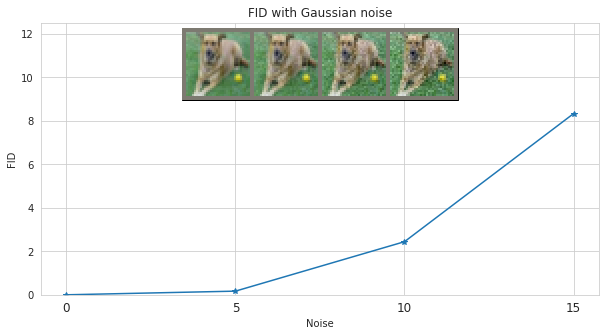

In [6]:
    

model_features, p = utility.get_features(model)
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="g", noise_level=[0,5,10,15])
utility.plot_fid(FID, plot_batch, ylim=120, xy = [1.5, 150*0.85], x_labels=[0,5,10,15], title = "FID with Gaussian noise")

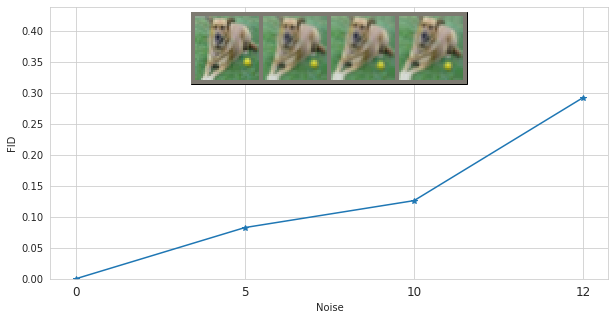

In [7]:
model_features, p = utility.get_features(model)
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="r", noise_level=[0,5,10,12])
utility.plot_fid(FID, plot_batch, ylim=50, xy = [1.5, 50*0.87], x_labels=[0,5,10,12])

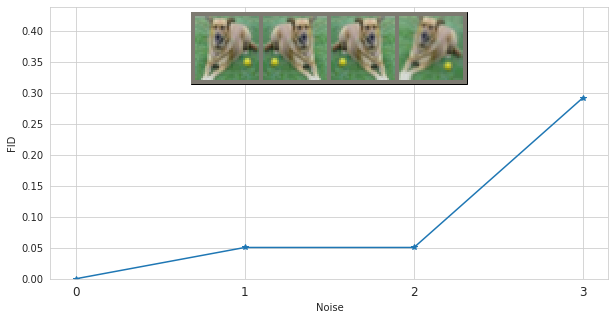

In [8]:
model_features, p = utility.get_features(model)
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="all", noise_level=[0,5,10,12])
utility.plot_fid(FID, plot_batch, ylim=100, xy = [1.5, 100*0.87])